In [1]:
%load_ext autoreload
%autoreload 2

Dataset Params:   0%|          | 0/1 [00:00<?, ?it/s]

            Date        Open        High         Low     Close   Adj Close  \
2856  2020-03-10  108.099998  111.580002  102.430000  0.269336  111.097923   
2857  2020-03-11  108.419998  108.900002  102.860001  0.206980  105.167252   
2858  2020-03-12   97.620003  100.000000   91.639999  0.063404   91.511749   
2859  2020-03-13  100.779999  102.870003   92.250000  0.175644  102.186958   
2860  2020-03-16   91.800003   98.279999   90.000000  0.096940   94.701363   
2861  2020-03-17   95.800003   97.459999   91.150002  0.081429   93.226166   

        Volume ticker       date  
2856  24083700    DIS 2020-03-10  
2857  24771300    DIS 2020-03-11  
2858  40392900    DIS 2020-03-12  
2859  40960100    DIS 2020-03-13  
2860  35379500    DIS 2020-03-16  
2861  27526200    DIS 2020-03-17  


Dataset Params: 100%|██████████| 1/1 [00:09<00:00,  9.77s/it]


,id,date,ticker,senti_label,original,text,industry
0,0,2020-08-31,AAPL,Bullish,$AAPL you better get back to $130 again 🤔,AAPL you better get back to again thinking face,Information Technology
1,1,2020-08-31,AAPL,Bullish,$AAPL now we just wait for power hour 😎💪🏾,AAPL now we just wait for power hour smiling f...,Information Technology
2,2,2020-08-31,AAPL,Bullish,$AAPL never thought I'd buy this 💰,AAPL never thought I d buy this money bag,Information Technology
3,3,2020-08-31,AAPL,Bullish,$AAPL bought my first option ever with Apple f...,AAPL bought my first option ever with Apple fo...,Information Technology
4,4,2020-08-31,AAPL,Bullish,"$AAPL Buy low, hold for another split in a cou...",AAPL Buy low hold for another split in a coupl...,Information Technology
...,...,...,...,...,...,...,...
50276,50276,2020-10-08,LOW,Bullish,$LOW Why isn’t this trending yet 🤔,LOW Why isn t this trending yet thinking face,Consumer Discretionary
50277,50277,2020-10-08,LOW,Bullish,$LOW Show us some strength and push over $170‼️,LOW Show us some strength and push over double...,Consumer Discretionary
50278,50278,2020-11-11,LOW,Bullish,$LOW retail investors will keep adding until ...,LOW retail investors will keep adding until ea...,Consumer Discretionary
50279,50279,2020-12-09,LOW,Bullish,$LOW in 10mins Squeeze Zone possible morning s...,LOW in mins Squeeze Zone possible morning spik...,Consumer Discretionary


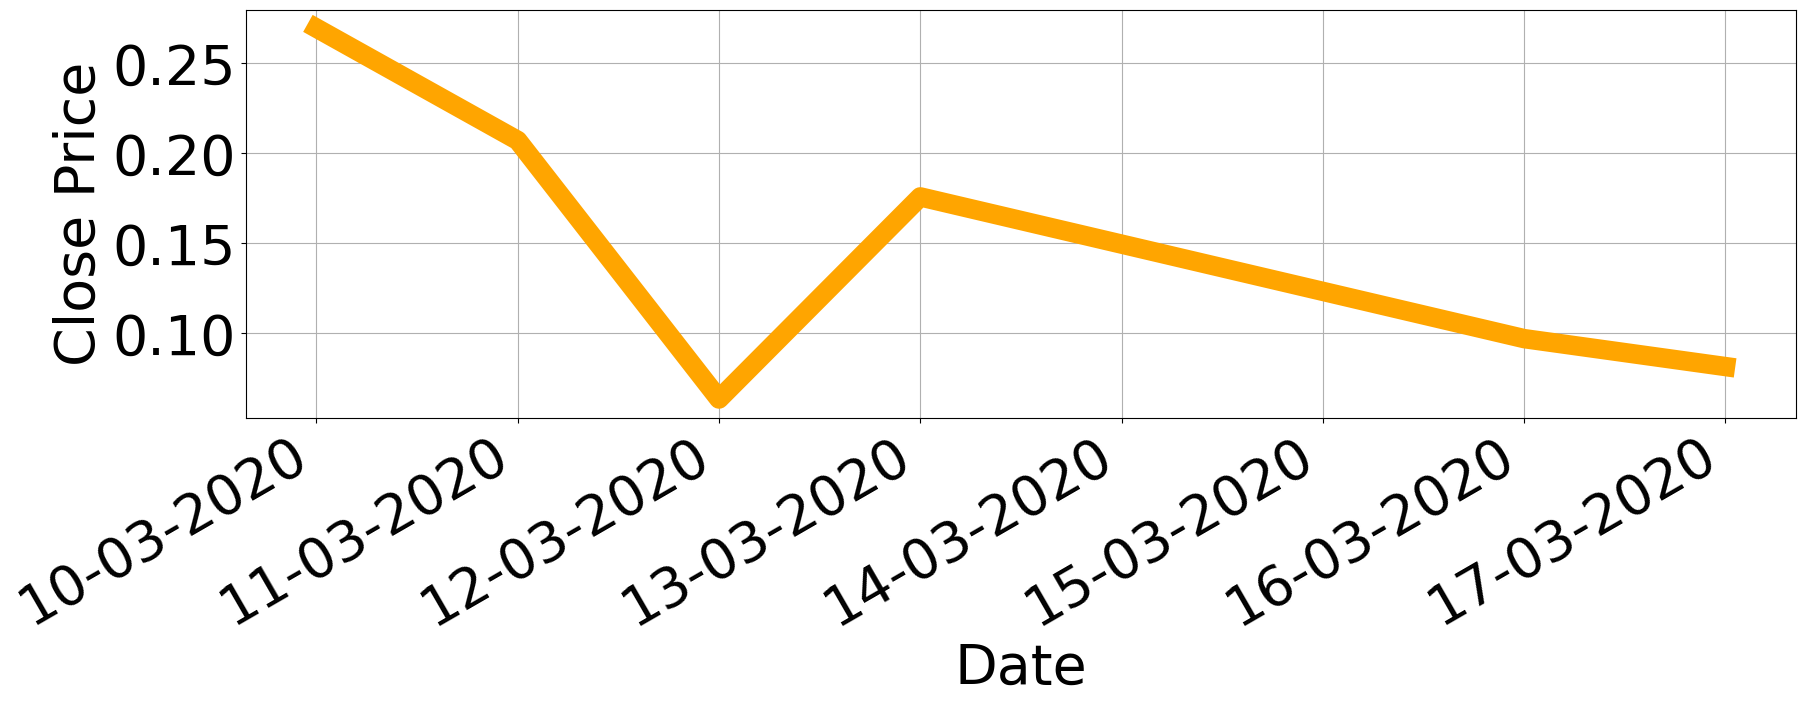

In [75]:
import data_helper_v3 as dh3
import itertools
from tqdm import tqdm
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import model_helper as mh
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig
import time
from transformers import AutoTokenizer
import pdb
import matplotlib.dates as mdates

SAVE_PATH = './images/'

def set_seed(seed, device):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device != 'cpu' and device != None:        
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def plot_original_ts(ts_df, save_file, mode='ticker', date_pairs=None, font_size=40):
    ts_df['Date'] = pd.to_datetime(ts_df['Date'])

    if mode == 'ticker':
        # Plot each ticker with a unique color
        plt.figure(figsize=(20, 6))
        for ticker in ts_df['ticker'].unique():
            ticker_df = ts_df[ts_df['ticker'] == ticker]
            if ticker == 'DIS': colour = 'orange'
            elif ticker == "AAPL": colour = None
            plt.plot(ticker_df['Date'], ticker_df['Close'], label=ticker, color=colour, linewidth=14)

        #plt.legend(title='Ticker', loc='upper center', bbox_to_anchor=(0.5, 0), ncol=14, 
        #           bbox_transform=plt.gcf().transFigure)#, fontsize=40)
        plt.xlabel('Date', fontsize=font_size)
        plt.ylabel('Close Price', fontsize=font_size)
        #plt.title('Close Price Over Time by Ticker')#, fontsize=50)
        plt.grid(True)
        
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) # Set major ticks to daily intervals
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))  # Format date as day-month-year

        # Rotate x-axis labels for better readability
        plt.gcf().autofmt_xdate()
        plt.xticks(fontsize=font_size)  # Larger font for x-axis ticks
        plt.yticks(fontsize=font_size)  # Larger font for y-axis ticks
        if date_pairs:
            print(date_pairs)
            ymin, ymax = plt.gca().get_ylim()  # Get the current y-axis limits
            for start_date, end_date in date_pairs:
                # Highlight the range between start_date and end_date, and span the full y-axis range
                plt.axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), 
                            color='gray', edgecolor='gray', linestyle='--', linewidth=1, 
                            ymin=0, ymax=1)  # Ensure the box spans the entire y-axis

    elif mode == 'industry':
        # Ensure 'industry' column exists in the dataframe
        if 'industry' not in ts_df.columns:
            raise ValueError("Industry mode selected, but 'industry' column is missing in ts_df")

        industries = ts_df['industry'].unique()
        industry_colors = plt.cm.get_cmap('tab10', len(industries))  # Assign colors to industries

        plt.figure(figsize=(20, 6))
        # Plot each ticker, colored by its industry
        for idx, industry in enumerate(industries):
            industry_df = ts_df[ts_df['industry'] == industry]
            for ticker in industry_df['ticker'].unique():
                ticker_df = industry_df[industry_df['ticker'] == ticker]
                # Label the plot with both industry and ticker
                plt.plot(ticker_df['Date'], ticker_df['Close'], label=f'{industry} - {ticker}', color=industry_colors(idx))

        plt.legend(title='Industry - Ticker', loc='upper center', bbox_to_anchor=(0.5, 0), ncol=8, 
                   bbox_transform=plt.gcf().transFigure)
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.title('Close Price Over Time by Industry and Ticker')
        plt.grid(True)

    elif mode == 'industry_subplot':
        # Ensure 'industry' column exists in the dataframe
        if 'industry' not in ts_df.columns:
            raise ValueError("Industry subplot mode selected, but 'industry' column is missing in ts_df")

        industries = ts_df['industry'].unique()
        num_industries = len(industries)
        
        # Create a subplot for each industry
        fig, axes = plt.subplots(num_industries, 1, figsize=(20, 6 * num_industries), sharex=True)

        if num_industries == 1:
            axes = [axes]  # Ensure axes is iterable even if there's only one subplot

        # Plot for each industry in its own subplot
        for idx, industry in enumerate(industries):
            industry_df = ts_df[ts_df['industry'] == industry]
            ax = axes[idx]
            tickers = industry_df['ticker'].unique()
            ticker_colors = plt.cm.get_cmap('tab10', len(tickers))  # Assign colors to tickers
            
            for t_idx, ticker in enumerate(tickers):
                ticker_df = industry_df[industry_df['ticker'] == ticker]
                ax.plot(ticker_df['Date'], ticker_df['Close'], label=ticker, color=ticker_colors(t_idx))
            
            ax.set_title(f'Close Price Over Time for Industry: {industry}')
            ax.set_ylabel('Close Price')
            ax.legend(title='Ticker', loc='upper left')
            ax.grid(True)
        
        plt.xlabel('Date')
        plt.tight_layout()

    # Save the plot to a local file
    time.sleep(2)
    plt.savefig(save_file + ".png")


def add_industry_labels(df, dataset_name):
     if dataset_name == 'stock_emotion':
        industry_df = pd.read_csv('./data/stock_emotions/tweet/processed_stockemo.csv')
        
        # Drop duplicates to ensure a unique mapping between tickers and industries
        df_unique = industry_df[['ticker', 'industry']].drop_duplicates()
    
        # Create a dictionary mapping ticker to industry
        ticker_to_industry = dict(zip(df_unique['ticker'], df_unique['industry']))
     elif dataset_name == 'stock_net':
        stock_df = pd.read_csv('./data/stocknet/StockTable.txt', sep='\t')
        stock_df['Symbol'] = stock_df['Symbol'].str.replace('$', '', regex=False)
        # Create a dictionary mapping ticker (Symbol) to industry (Sector)
        ticker_to_industry = dict(zip(stock_df['Symbol'], stock_df['Sector']))
        
        
     elif dataset_name == 'EDT':
          raise NotImplementedError
     df['industry'] = df['ticker'].map(ticker_to_industry)

     df['industry'] = df['industry'].fillna('no industry given')
     return df

def plot_list_as_hist(list_freqs, xlabel, title, colour):
    plt.figure(figsize=(12, 10))
    plt.hist(list_freqs, bins=range(min(list_freqs), max(list_freqs) + 2), edgecolor=colour, color = colour)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True)
    #plt.xticks(rotation=45, ha='right')
    # Save the histogram to a file
    title = title.replace("\n", " ")
    title = title.replace(":", " ")
    save_name = f'{title}_histogram.png'
    plt.savefig(SAVE_PATH + save_name)

def plot_text_counts(counts, xlabel, title, colour):
    
    # Count occurrences of each number of texts
    count_values = counts.value_counts().sort_index()
    
    plt.figure(figsize=(12, 10))
    count_values.plot(kind='bar', color=colour, edgecolor='black')

    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.title(title)
    plt.grid(axis='y')

    title = title.replace("\n", " ")
    title = title.replace(":", " ")

    save_name = f'{title}_column_graph.png'
    plt.savefig(SAVE_PATH + save_name)

def plot_text_examples_per_ticker(df, title, colour):
    # Count the number of text examples per ticker
    text_counts = df['ticker'].value_counts()
    
    # Plot as a column graph (bar plot)
    plt.figure(figsize=(16, 14))
    text_counts.plot(kind='bar', color=colour, edgecolor=colour)

    plt.xlabel('Ticker')
    plt.ylabel('Number of Text Examples')
    plt.title(title)
    plt.grid(axis='y')
    plt.xticks(rotation=45, ha='right', fontsize=7)
    # Save the plot to a local file
    plt.savefig(f'{SAVE_PATH}{title}.png')

dataset_param_grid = {                                                                            
        "ts_window": [4],#6 & 7 had a random error out                                                                         
        "ts_overlap": ['start'],                                                                    
        "text_window": [1],#, 2, 3, 4], #4                                                                
        'text_selection_method': [('TFIDF', 5)],
        "data_source": [#{
        #    "name": "EDT",
        #    "text_path": "./data/EDT/evaluate_news.json",
        #    "ts_path": "./data/EDT/evaluate_news.json",
        #    "ts_date_col": 'Date',
        #    'text_date_col': 'date',
        #    'text_col': 'text',
        #    'train_dates': '01/01/2020 - 03/09/2020',
        #    'test_dates': '04/09/2020 - 31/12/2020',
        #    'plot_colour': 'darkorchid'
        #}#,
        {
            "name": "stock_emotion",
            "text_path": "./data/stock_emotions/tweet/processed_stockemo.csv",
            "ts_path": "./data/stock_emotions/price/",
            "ts_date_col": 'Date',
            'text_date_col': 'date',
            'text_col': 'text',
            'plot_colour': 'deepskyblue',
            'train_dates': '01/01/2020 - 03/09/2020',
            'test_dates': '04/09/2020 - 31/12/2020'
        }#,{
        #    "name": "stock_net",
        #    "text_path": "./data/stocknet/tweet/organised_tweet.csv",
        #    "ts_path": "./data/stocknet/price/raw/",
        #    "ts_date_col": 'Date',
        #    'text_date_col': 'created_at',
        #    'text_col': 'text',
        #    'plot_colour': 'mediumseagreen',
        #    'train_dates': '01/01/2014 - 01/08/2015',
        #    'test_dates': '01/08/2015 - 01/01/2016'
        #}
        ],                                                            
        "negatives_creation": [("naive", 60)],                          
        "random_state": [42],
    }

dataset_permutations = list(itertools.product(*dataset_param_grid.values()))
dataset_combinations = [dict(zip(dataset_param_grid.keys(), perm)) for perm in dataset_permutations]
for dataset_params in tqdm(dataset_combinations, desc='Dataset Params', position=0):        
        #====================================================
        #dataset params
        #====================================================
        ts_window                   = dataset_params['ts_window']
        ts_overlap                  = dataset_params['ts_overlap']
        text_window                 = dataset_params["text_window"]
        text_selection_method       = dataset_params['text_selection_method']
        data_source                 = dataset_params["data_source"]
        negatives_creation          = dataset_params['negatives_creation']
        random_state                = dataset_params["random_state"] #effects everything but first call is the ds creation
        plot_colour                 = data_source['plot_colour']
        set_seed(random_state, device=None)

        text_df, ts_df = dh3.wrangle_data(data_source)
        ts_df = dh3.normalize_ts(ts_df)
        
        df = dh3.get_data(text_tokenizer=None, 
            data_source=data_source, 
            ts_window=ts_window, 
            ts_mode=ts_overlap, 
            text_window=text_window, 
            text_selection_method=text_selection_method, 
            negatives_creation=negatives_creation, 
            batch_size=None, 
            num_workers=None, 
            loaders=False,
            subset_data=False)
        
        #ts_df = add_industry_labels(df=ts_df, dataset_name=data_source['name'])
        #text_df = add_industry_labels(df=text_df, dataset_name=data_source['name'])
        #df = add_industry_labels(df=df, dataset_name=data_source['name'])

        #for each dataset permutation get:
        #base dataset:
            #1. lenghts of individual texts characters/tokens
        #tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        #lengths_of_original_texts = text_df[data_source['text_col']].apply(len)
        #lengths_of_tokenized_texts = text_df[data_source['text_col']].apply(lambda text: len(tokenizer.tokenize(text)))
        #plot_list_as_hist(lengths_of_original_texts, xlabel="Length of Original Text (Characters)", title=f"Histogram of Character Lengths of Texts in Original {data_source['name']} Dataset",
        #                  colour=plot_colour)
        #plot_list_as_hist(lengths_of_tokenized_texts, xlabel="Length of Original Text (Tokens)", title=f"Histogram of Number of Tokens in Original {data_source['name']} Dataset",
        #                  colour=plot_colour)
        #    #2. words associated with a ticker 
        #    #3. time series differences in distribution / rises and falls
        #plot_text_examples_per_ticker(text_df, title=f"Number of Texts Per Ticker {data_source['name']}", colour=plot_colour)
#       
        ts_df = ts_df[ts_df['ticker'].isin(["DIS"])]#, "AAPL"])]

        #late dates
        start_date = '2020-08-03'
        end_date = '2020-08-10'

        #early dates
        start_date = '2020-03-10'
        end_date = '2020-03-17'
        date_pairs = None
        #date_pairs = [(start_date, end_date)]

        # Filter the DataFrame to include only rows where 'Date' is between the start and end date
        ts_df = ts_df.loc[(ts_df['Date'] >= start_date) & (ts_df['Date'] <= end_date)]
        print(ts_df)
        ##TODO colour by industry label!!
        plot_original_ts(ts_df=ts_df, save_file=SAVE_PATH + data_source['name'] + "_original_ts_graph_ticker_dis_and_appl", mode='ticker', date_pairs=date_pairs)
        #plot_original_ts(ts_df=ts_df, save_file=SAVE_PATH + data_source['name'] + "_original_ts_graph_industry", mode='industry')
        #plot_original_ts(ts_df=ts_df, save_file=SAVE_PATH + data_source['name'] + "_original_ts_graph_industry_subplot", mode='industry_subplot')
        
        #
        ##processed data:
        #    #1. length of texts selected
#
        #lengths_of_selected_texts = [len(text) for sublist in df['text_series'] for text in sublist]
        #lengths_of_tokenized_selected_texts = [len(tokenizer.tokenize(text)) for sublist in df['text_series'] for text in sublist]
        #plot_list_as_hist(lengths_of_selected_texts, 
        #                  xlabel="Length of Selected Text (Characters)", 
        #                  title=f"Histogram of Character Lengths of Texts Selected Per Pair from {data_source['name']} Dataset\nParameters: Text Selection {text_selection_method}, Text Window {text_window}, Random State {random_state}",
        #                  colour=plot_colour)
        #plot_list_as_hist(lengths_of_tokenized_selected_texts, 
        #                  xlabel="Length of Selected Text (Tokens)", 
        #                  title=f"Histogram of Number of Tokens in Selected Pairs {data_source['name']} Dataset\nParameters: Text Selection {text_selection_method}, Text Window {text_window}, Random State {random_state}",
        #                  colour=plot_colour)
        #    #2. number of texts found (some are substituted with empty strings)
        #number_of_texts_per_example = df['text_series'].apply(lambda x: len([text for text in x if text != ""]))
        #plot_text_counts(number_of_texts_per_example, 
        #                  xlabel='Number of Texts Selected Per Pair', 
        #                  title=f"Number of Texts Selected Per Pair from {data_source['name']} Dataset\nParameters: Text Selection {text_selection_method}, Text Window {text_window}, Random State {random_state}",
        #                  colour=plot_colour)
        #
        #    #3. base embeddings similarities and distances between pos / neg pairs
        #    #3. base embedding distributions 
#
        #
            
text_df


In [11]:
ts_df

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2012-09-04,95.108574,96.448570,94.928574,0.375340,87.121140,91973000.0,AAPL
1,2012-09-05,96.510002,96.621429,95.657143,0.369085,86.509338,84093800.0,AAPL
2,2012-09-06,96.167145,96.898575,95.828575,0.377055,87.288956,97799100.0,AAPL
3,2012-09-07,96.864288,97.497147,96.538574,0.382558,87.827171,82416600.0,AAPL
4,2012-09-10,97.207146,97.612854,94.585716,0.359201,85.542564,121999500.0,AAPL
...,...,...,...,...,...,...,...,...
108587,2017-08-28,76.900002,76.940002,76.260002,0.217550,76.470001,8229700.0,XOM
108588,2017-08-29,76.209999,76.489998,76.080002,0.216989,76.449997,7060400.0,XOM
108589,2017-08-30,76.239998,76.449997,76.059998,0.207177,76.099998,8218000.0,XOM
108590,2017-08-31,76.269997,76.489998,76.050003,0.213625,76.330002,15641700.0,XOM


C:\Users\eoinp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


torch.Size([2, 500])
torch.Size([2, 500])


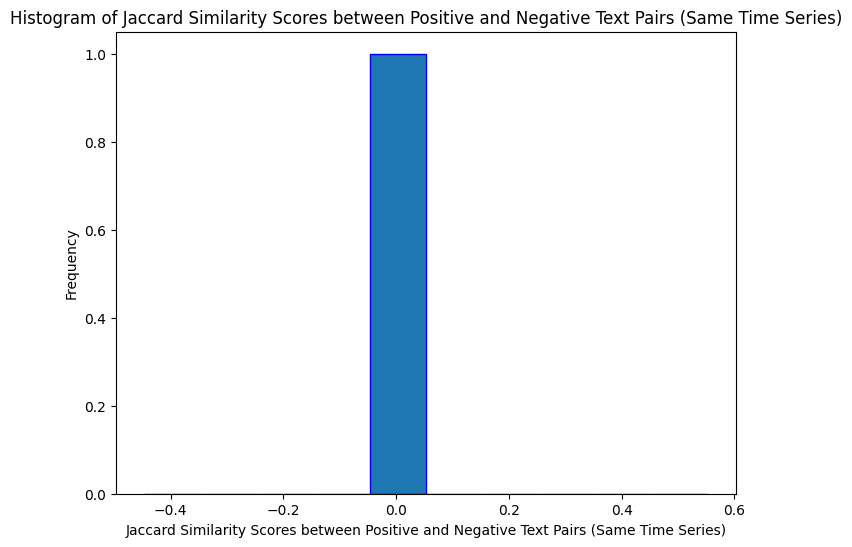

In [63]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig

def jaccard_similarity(list1, list2):
    set1 = set(" ".join(list1).split())
    set2 = set(" ".join(list2).split())
    return len(set1.intersection(set2)) / len(set1.union(set2))
i = 0

def plot_floats_as_hist(float_list, xlabel, title, colour):
    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(float_list, bins=10, edgecolor=colour)  # You can adjust 'bins' as needed

    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)

    # Show the plot
    plt.show()

def handle_tokenisation(time_series, text_series, past_time_features, tokenizer, label):
        #helper method reflecting the custom dataset class' input processing
        ts_data = [{
            "past_time_values": torch.tensor(time_series, dtype=torch.float32),
            "past_observed_mask": torch.ones(1, len(time_series), dtype=torch.long),
            "past_time_features": torch.tensor([past_time_features], dtype=torch.float32)
        }]

        #loop over all text and tokenize
        text_data = [tokenizer.text_tokenizer(text, return_tensors="pt", truncation=True, padding='max_length') for text in text_series]
        
        input_ids = torch.stack([item['input_ids'].squeeze(0) for item in text_data])  # Shape: [number_of_texts, length_of_text]
        attention_mask = torch.stack([item['attention_mask'].squeeze(0) for item in text_data])  # Shape: [number_of_texts, length_of_text]
        text_data = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

        label = torch.tensor(label, dtype=torch.long)
        return ts_data, text_data, label

def get_similarity_metrics(df, model, tokenizer, device):
    model.to(device)
    jaccard_similarities = []
    df = dh3.correct_negative_labels(df, negative_label=-1)
    i = 0
    for unique_ts_id in df['ts_id'].unique().tolist():
        
        #print(df[df["ts_id"] == unique_ts_id])
        positive_text = df[(df["ts_id"] == unique_ts_id) & (df["label"] == 1)]
        negative_text = df[(df["ts_id"] == unique_ts_id) & (df["label"] == -1)]
        
        #get jaccard similarity
        jaccard_similarity_score = jaccard_similarity(positive_text['text_series'].tolist()[0], negative_text['text_series'].tolist()[0])
        jaccard_similarities.append(jaccard_similarity_score)
        #get embedding similarity between pos and neg text pairs
        filtered_df = df[(df["ts_id"] == unique_ts_id)]

        #get embedding similarity between positive text / ts and negative text / ts
        data_loader = DataLoader(dh3.CustomDataset(df=filtered_df, text_tokenizer=tokenizer, ts_col='time_series', text_col='text_series', label_col='label'), batch_size=2, shuffle=False)
        
        for ts_data, text_data, labels in data_loader:
            ts_data = {
                "past_time_values": torch.stack([d['past_time_values'].squeeze(1) for d in ts_data], dim=0).to(device),
                "past_observed_mask": torch.stack([d['past_observed_mask'].squeeze(0) for d in ts_data], dim=0).to(device),
                "past_time_features": torch.stack([d['past_time_features'].squeeze(0) for d in ts_data], dim=0).to(device)
            }
            text_data['input_ids'] = text_data['input_ids'].to(device)
            text_data['attention_mask'] = text_data['attention_mask'].to(device)
            
            ts_embeddings, text_embeddings = model(ts_data, text_data)
            similarity = cosine_similarity(ts_embeddings, text_embeddings)
        #positive_ts_data, positive_text_data, positive_label = handle_tokenisation(time_series=positive_text['time_series'], 
        #                                                                           text_series=positive_text['text_series'],
        #                                                                           past_time_features=positive_text['past_time_features'], 
        #                                                                           tokenizer=tokenizer, 
        #                                                                           label=positive_text['label'])
        #negative_ts_data, negative_text_data, negative_label = handle_tokenisation(time_series=negative_text['time_series'], 
        #                                                                           text_series=negative_text['text_series'],
        #                                                                           past_time_features=negative_text['past_time_features'], 
        #                                                                           tokenizer=tokenizer, 
        #                                                                           label=negative_text['label'])
        

        

        i += 1
        if i > 0:
            break
    plot_floats_as_hist(float_list=jaccard_similarities, xlabel="Jaccard Similarity Scores between Positive and Negative Text Pairs (Same Time Series)", title="Histogram of Jaccard Similarity Scores between Positive and Negative Text Pairs (Same Time Series)", colour="blue")

model_param_grid = {
            "ts_encoder": [{"name": 'TimeSeriesTransformerModel'}],#{"name": 'AutoFormerModel'}, {"name": "InformerModel"}],
            "text_encoder": [{"name": 'bert-base-uncased'}, {"name": 'bert-base-cased'}],                                                                     
            "text_aggregation_method": ["mean", 'max'],                                                    
            "projection_dim": [500],  
        }

ts_encoder                  = model_param_grid["ts_encoder"][0]
ts_encoder['ts_window']     = 4
ts_encoder['context_length'] = 1
ts_encoder['prediction_length']= 0
ts_encoder['lags_sequence'] = [i + 1 for i in range(ts_window - 1)]
ts_encoder['num_features']  = 3
projection_dim = model_param_grid['projection_dim'][0]
text_encoder                = model_param_grid["text_encoder"][0]
text_aggregation = model_param_grid['text_aggregation_method'][0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(text_encoder['name'])
model = mh.get_model(ts_encoder_config=ts_encoder, text_encoder_config=text_encoder, projection_dim=projection_dim, ts_window=ts_window, text_aggregation=text_aggregation)
get_similarity_metrics(df=df, model=model, tokenizer=tokenizer, device=device)

In [48]:
df['time_series'].apply(len)

0       4
1       4
2       4
3       4
4       4
       ..
6457    4
6458    4
6459    4
6460    4
6461    4
Name: time_series, Length: 6462, dtype: int64

In [1]:
import pandas as pd
df = pd.read_csv("./data/stocknet/tweet/organised_tweet.csv")

In [4]:
df.columns


Index(['Unnamed: 0', 'created_at', 'id', 'id_str', 'text', 'source',
       'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'retweeted_status', 'retweet_count', 'favorite_count',
       'entities', 'favorited', 'retweeted', 'filter_level', 'lang',
       'possibly_sensitive', 'ticker', 'timestamp_ms', 'extended_entities',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status',
       'is_quote_status'],
      dtype='object')

In [44]:
df = pd.read_csv("./data/stock_emotions/tweet/processed_stockemo.csv")

In [45]:
df['industry'].value_counts()

industry
Consumer Discretionary    29279
Information Technology    11291
Industrials                4246
Communication Services     3032
Health Care                1166
Consumer Staples            731
Financials                  385
Energy                      149
Real Estate                   2
Name: count, dtype: int64